In [1]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PREDICCIÓN DE DEMANDA TURÍSTICA EN MENDOZA
════════════════════════════════════════════════════════════════════════════════

OBJETIVO PREDICTIVO:
   Predecir el número mensual de turistas que visitan Mendoza según:
   - Características económicas (precio USD)
   - Características temporales (mes, año)
   - Origen del turista (país)
   - Punto de entrada (aeropuerto, paso fronterizo)

TIPO DE PROBLEMA: Regresión
   - Variable objetivo: turistas (numérica continua)
   - Métricas: RMSE, MAE, R²

DATASET: mendoza_turismo_final_filtrado.csv
   - Período: 2014-2025
   - Registros mensuales agregados por país y punto de entrada
   
════════════════════════════════════════════════════════════════════════════════
"""

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Estilo de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Configuración completa")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"🎲 Semilla aleatoria: {RANDOM_STATE}")

✅ Configuración completa
📅 Fecha: 2025-10-26 23:41
🎲 Semilla aleatoria: 42



📂 CARGA DE DATOS
✅ Dataset cargado: 2,877 filas × 31 columnas

--------------------------------------------------------------------------------
🔍 ESTRUCTURA DEL DATASET
--------------------------------------------------------------------------------
  indice_tiempo               pais_origen       punto_entrada  turistas  \
0       2014-01                    Brasil  Aeropuerto Córdoba       654   
1       2014-01                     Chile  Aeropuerto Córdoba      1046   
2       2014-01    Ee.Uu, Canadá Y México  Aeropuerto Córdoba      1211   
3       2014-01  Europa Y Resto Del Mundo  Aeropuerto Córdoba       719   
4       2014-01          Resto De América  Aeropuerto Córdoba       763   

   precio_promedio_usd  precio_minimo_usd  precio_maximo_usd  dias  \
0                  7.1                6.0                8.0    31   
1                  7.1                6.0                8.0    31   
2                  7.1                6.0                8.0    31   
3                 

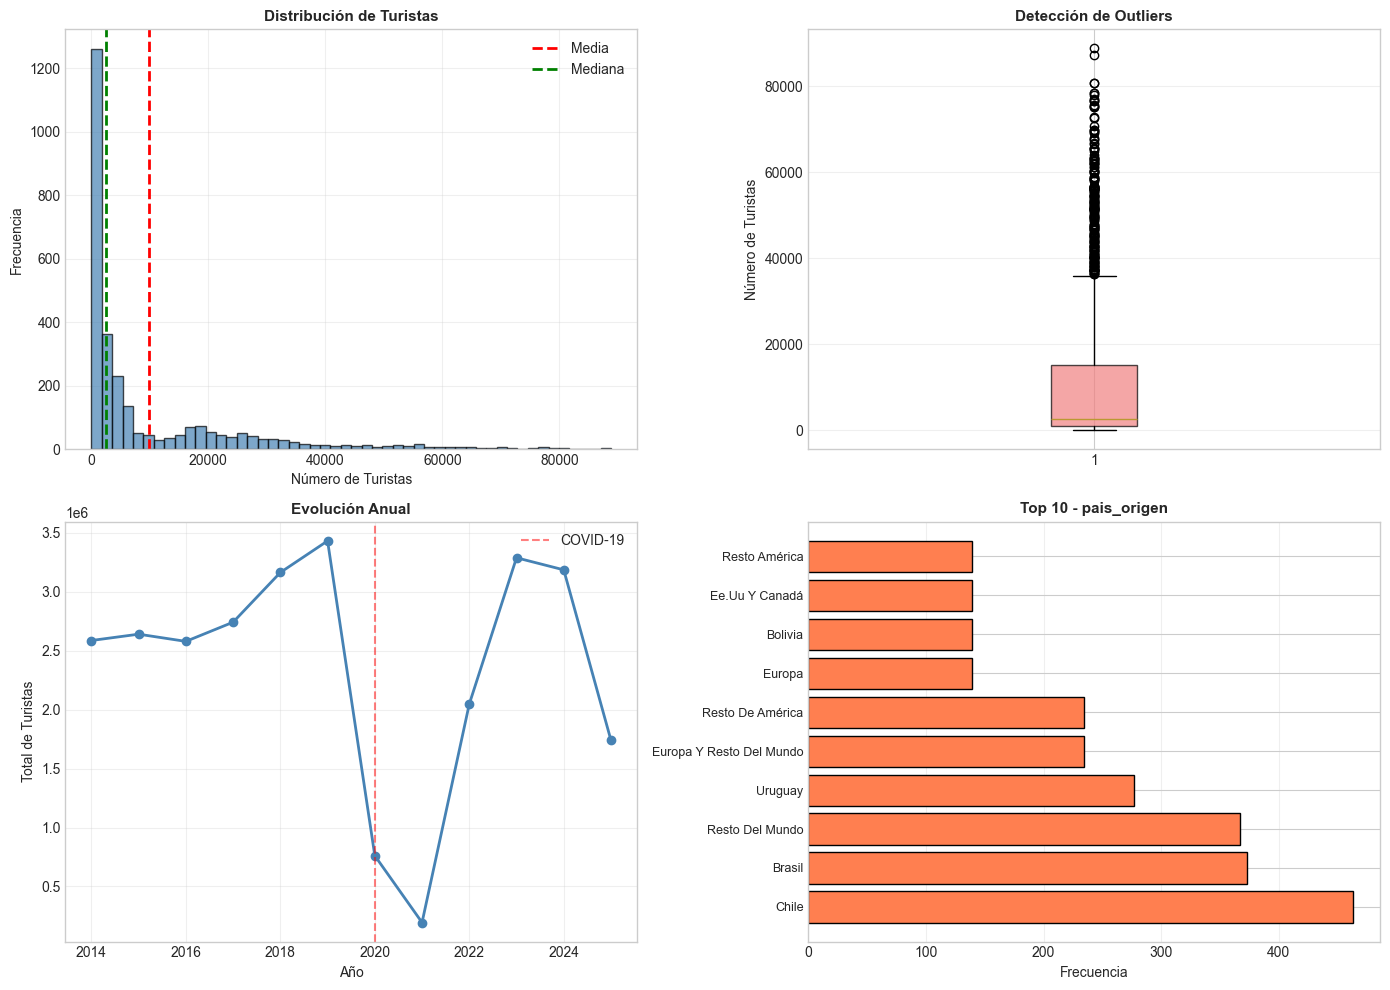

✅ Exploración completada


In [2]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 1: EXPLORACIÓN DE DATOS
════════════════════════════════════════════════════════════════════════════════
Objetivo: Conocer la estructura, calidad y características del dataset
"""

# ═══ CARGA DE DATOS ═══
print("\n" + "="*80)
print("📂 CARGA DE DATOS")
print("="*80)

df = pd.read_csv('mendoza_turismo_final_filtrado.csv', sep=';', encoding='utf-8')
print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")

# ═══ INSPECCIÓN INICIAL ═══
print("\n" + "-"*80)
print("🔍 ESTRUCTURA DEL DATASET")
print("-"*80)
print(df.head())

print("\n📊 Información de columnas:")
df.info()

# ═══ ANÁLISIS DE LA VARIABLE OBJETIVO ═══
print("\n" + "-"*80)
print("🎯 ANÁLISIS DE LA VARIABLE OBJETIVO: 'turistas'")
print("-"*80)
print(df['turistas'].describe())
print(f"\n   • Media: {df['turistas'].mean():,.0f} turistas/mes")
print(f"   • Mediana: {df['turistas'].median():,.0f} turistas/mes")
print(f"   • Desviación estándar: {df['turistas'].std():,.0f}")
print(f"   • Rango: {df['turistas'].min():,.0f} - {df['turistas'].max():,.0f}")

# ═══ IDENTIFICACIÓN DE TIPOS DE VARIABLES ═══
print("\n" + "-"*80)
print("📋 CLASIFICACIÓN DE VARIABLES")
print("-"*80)

# Variables numéricas (excluyendo objetivo)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'turistas' in numeric_features:
    numeric_features.remove('turistas')

# Variables categóricas
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Eliminar columnas de fecha si existen (no son predictoras directas)
date_columns = ['indice_tiempo', 'fecha', 'mes_ano']
for col in date_columns:
    if col in categorical_features:
        categorical_features.remove(col)
    if col in numeric_features:
        numeric_features.remove(col)

print(f"   • Variables numéricas: {len(numeric_features)}")
for feat in numeric_features[:10]:
    print(f"      - {feat}")
if len(numeric_features) > 10:
    print(f"      ... y {len(numeric_features) - 10} más")

print(f"\n   • Variables categóricas: {len(categorical_features)}")
for feat in categorical_features:
    print(f"      - {feat} ({df[feat].nunique()} categorías)")

# ═══ DETECCIÓN DE PROBLEMAS DE CALIDAD ═══
print("\n" + "-"*80)
print("🔍 CALIDAD DE LOS DATOS")
print("-"*80)

# Valores nulos
nulos_totales = df.isnull().sum().sum()
if nulos_totales > 0:
    print(f"⚠️  {nulos_totales} valores nulos encontrados:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    
    # Eliminar columnas completamente nulas
    null_cols = df.columns[df.isnull().all()].tolist()
    if null_cols:
        df = df.drop(columns=null_cols)
        # Actualizar listas de features
        numeric_features = [f for f in numeric_features if f not in null_cols]
        categorical_features = [f for f in categorical_features if f not in null_cols]
        print(f"   ✅ Eliminadas columnas completamente nulas: {null_cols}")
else:
    print("✅ No hay valores nulos")

# Outliers en target
Q1 = df['turistas'].quantile(0.25)
Q3 = df['turistas'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df['turistas'] < Q1 - 1.5*IQR) | (df['turistas'] > Q3 + 1.5*IQR)).sum()
print(f"\n📊 Outliers en target: {outliers} ({outliers/len(df)*100:.1f}%)")
print(f"   → Decisión: Mantenerlos (pueden ser períodos de alta demanda real)")

# ═══ VISUALIZACIÓN INICIAL ═══
print("\n" + "-"*80)
print("📊 VISUALIZACIONES EXPLORATORIAS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribución del target
axes[0, 0].hist(df['turistas'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['turistas'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
axes[0, 0].axvline(df['turistas'].median(), color='green', linestyle='--', linewidth=2, label='Mediana')
axes[0, 0].set_xlabel('Número de Turistas', fontsize=10)
axes[0, 0].set_ylabel('Frecuencia', fontsize=10)
axes[0, 0].set_title('Distribución de Turistas', fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot
axes[0, 1].boxplot(df['turistas'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightcoral', alpha=0.7))
axes[0, 1].set_ylabel('Número de Turistas', fontsize=10)
axes[0, 1].set_title('Detección de Outliers', fontsize=11, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Evolución temporal (si existe columna año)
if 'año' in df.columns:
    turistas_por_año = df.groupby('año')['turistas'].sum()
    axes[1, 0].plot(turistas_por_año.index, turistas_por_año.values, 
                    marker='o', linewidth=2, markersize=6, color='steelblue')
    axes[1, 0].set_xlabel('Año', fontsize=10)
    axes[1, 0].set_ylabel('Total de Turistas', fontsize=10)
    axes[1, 0].set_title('Evolución Anual', fontsize=11, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # Identificar año con mayor caída (pandemia)
    cambios = turistas_por_año.pct_change() * 100
    año_mayor_caida = cambios.idxmin()
    if año_mayor_caida == 2020:
        axes[1, 0].axvline(2020, color='red', linestyle='--', alpha=0.5, label='COVID-19')
        axes[1, 0].legend()

# Distribución por categoría principal (si existe)
if categorical_features:
    cat_principal = categorical_features[0]
    top_categorias = df[cat_principal].value_counts().head(10)
    axes[1, 1].barh(range(len(top_categorias)), top_categorias.values, color='coral', edgecolor='black')
    axes[1, 1].set_yticks(range(len(top_categorias)))
    axes[1, 1].set_yticklabels(top_categorias.index, fontsize=9)
    axes[1, 1].set_xlabel('Frecuencia', fontsize=10)
    axes[1, 1].set_title(f'Top 10 - {cat_principal}', fontsize=11, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Exploración completada")

In [3]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 2: PREPARACIÓN DE DATOS Y CONSTRUCCIÓN DEL PIPELINE
════════════════════════════════════════════════════════════════════════════════
Objetivo: Crear un pipeline completo de Scikit-learn que integre:
   1. Preprocesamiento de variables numéricas (imputación + escalado)
   2. Preprocesamiento de variables categóricas (imputación + encoding)
   3. Partición train/test temporal
"""

# ═══ SEPARACIÓN FEATURES Y TARGET ═══
print("\n" + "="*80)
print("📊 PREPARACIÓN DE VARIABLES")
print("="*80)

X = df[numeric_features + categorical_features].copy()
y = df['turistas'].copy()

print(f"✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")
print(f"\n   Variables predictoras:")
print(f"      • Numéricas: {len(numeric_features)}")
print(f"      • Categóricas: {len(categorical_features)}")

# ═══ ESTRATEGIA DE PARTICIÓN ═══
print("\n" + "-"*80)
print("✂️ ESTRATEGIA DE PARTICIÓN")
print("-"*80)

print("""
Estrategia elegida: SPLIT TEMPORAL (80/20)

Justificación:
   • Los datos son series temporales (mensuales)
   • Queremos simular predicción del futuro con datos del pasado
   • Train/Test respeta el orden cronológico
   • Evita data leakage temporal

Distribución:
   • Train: 80% primeros datos (aprende de historia)
   • Test: 20% últimos datos (evalúa en futuro)
""")

# Split temporal
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"✅ Train set: {len(X_train):,} registros ({len(X_train)/len(X)*100:.1f}%)")
print(f"✅ Test set: {len(X_test):,} registros ({len(X_test)/len(X)*100:.1f}%)")

# Estadísticas train/test
print(f"\n📊 Estadísticas del target:")
print(f"   Train - Media: {y_train.mean():,.0f} ± {y_train.std():,.0f}")
print(f"   Test  - Media: {y_test.mean():,.0f} ± {y_test.std():,.0f}")

# ═══ CONSTRUCCIÓN DEL PIPELINE DE PREPROCESAMIENTO ═══
print("\n" + "-"*80)
print("🔧 CONSTRUCCIÓN DEL PIPELINE DE SCIKIT-LEARN")
print("-"*80)

print("""
Pipeline de preprocesamiento con ColumnTransformer:

1️⃣ VARIABLES NUMÉRICAS:
   • Imputación: SimpleImputer (strategy='median')
      → Rellena valores faltantes con la mediana
      → Robusto a outliers
   
   • Escalado: StandardScaler
      → Normaliza a media=0, std=1
      → Necesario para modelos sensibles a escala (Ridge)

2️⃣ VARIABLES CATEGÓRICAS:
   • Imputación: SimpleImputer (strategy='constant', fill_value='missing')
      → Rellena nulos con categoría 'missing'
   
   • Encoding: OneHotEncoder (handle_unknown='ignore')
      → Crea columnas binarias para cada categoría
      → handle_unknown='ignore' maneja categorías nuevas en test

3️⃣ INTEGRACIÓN:
   • ColumnTransformer aplica transformaciones en paralelo
   • Mantiene nombres de columnas organizados
   • Compatible con cualquier modelo de Scikit-learn
""")

# Transformador para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer combina ambos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',  # Descartar columnas no especificadas
    n_jobs=-1  # Paralelizar
)

print("✅ Pipeline de preprocesamiento creado")

# Verificar transformación
print("\n🧪 Verificación del pipeline:")
print(f"   Entrada: {X_train.shape}")
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
print(f"   Salida: {X_train_transformed.shape}")
print(f"   → {X_train_transformed.shape[1] - len(numeric_features)} columnas categóricas creadas (one-hot)")

# ═══ VISUALIZACIÓN DEL PIPELINE ═══
print("\n" + "-"*80)
print("📊 ESTRUCTURA DEL PIPELINE")
print("-"*80)

from sklearn import set_config
set_config(display='diagram')

# Mostrar diagrama del preprocesador
print("\n🔧 Preprocesador:")
print(preprocessor)

print("\n✅ Preparación completada - Pipeline listo para modelado")


📊 PREPARACIÓN DE VARIABLES
✅ Features (X): (2877, 27)
✅ Target (y): (2877,)

   Variables predictoras:
      • Numéricas: 25
      • Categóricas: 2

--------------------------------------------------------------------------------
✂️ ESTRATEGIA DE PARTICIÓN
--------------------------------------------------------------------------------

Estrategia elegida: SPLIT TEMPORAL (80/20)

Justificación:
   • Los datos son series temporales (mensuales)
   • Queremos simular predicción del futuro con datos del pasado
   • Train/Test respeta el orden cronológico
   • Evita data leakage temporal

Distribución:
   • Train: 80% primeros datos (aprende de historia)
   • Test: 20% últimos datos (evalúa en futuro)

✅ Train set: 2,301 registros (80.0%)
✅ Test set: 576 registros (20.0%)

📊 Estadísticas del target:
   Train - Media: 9,421 ± 14,659
   Test  - Media: 11,601 ± 16,511

--------------------------------------------------------------------------------
🔧 CONSTRUCCIÓN DEL PIPELINE DE SCIKIT-LEARN



🤖 DEFINICIÓN DE MODELOS
✅ 3 modelos definidos con pipelines completos
   Cada pipeline incluye: preprocesamiento + modelo

--------------------------------------------------------------------------------
🏋️ ENTRENAMIENTO Y EVALUACIÓN
--------------------------------------------------------------------------------

🤖 Ridge Regression
   ⏳ Validación cruzada (5 folds)...
   ✅ CV RMSE: 10,664 ± 2,042
   ✅ CV R²: -5.4413
   ⏳ Entrenando en train completo...

   📊 Métricas Train:
      • RMSE: 8,688
      • MAE: 6,033
      • R²: 0.6485

   📊 Métricas Test:
      • RMSE: 59,429
      • MAE: 53,350
      • R²: -11.9775

   🔍 Diagnóstico:
      • Ratio Test/Train RMSE: 6.84x
      🚨 Overfitting severo

🤖 Random Forest
   ⏳ Validación cruzada (5 folds)...
   ✅ CV RMSE: 8,376 ± 4,684
   ✅ CV R²: -4.4937
   ⏳ Entrenando en train completo...

   📊 Métricas Train:
      • RMSE: 1,273
      • MAE: 536
      • R²: 0.9925

   📊 Métricas Test:
      • RMSE: 7,268
      • MAE: 3,959
      • R²: 0.8059

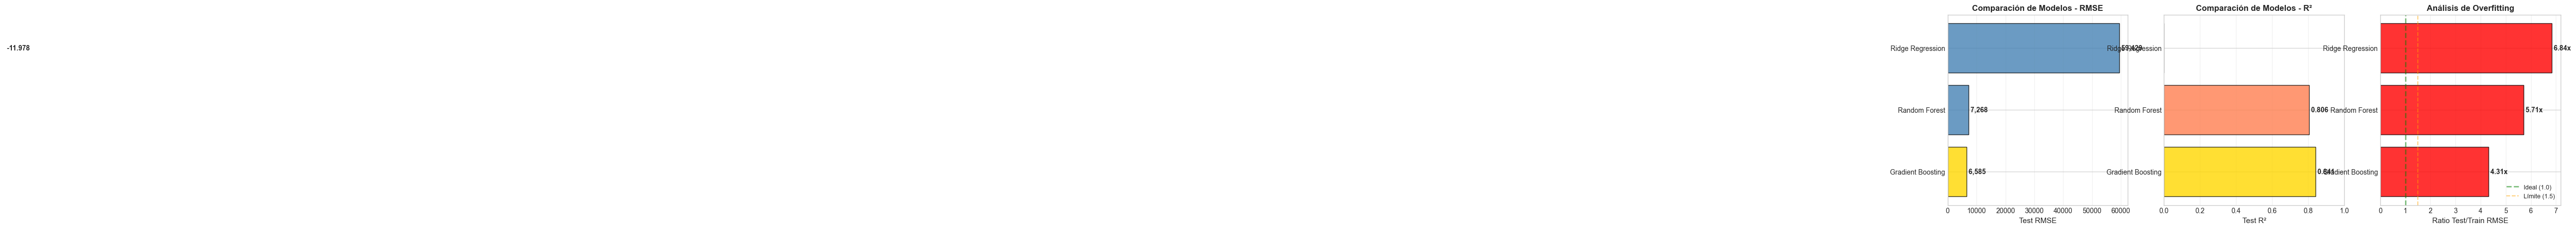

✅ Comparación completada - Mejor modelo seleccionado


In [4]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 3: COMPARACIÓN DE MODELOS
════════════════════════════════════════════════════════════════════════════════
Objetivo: Evaluar 3 modelos diferentes y seleccionar el mejor

Modelos a comparar:
   1. Ridge Regression (lineal con regularización L2)
   2. Random Forest (ensemble de árboles)
   3. Gradient Boosting (boosting secuencial)

Estrategia de evaluación:
   • Validación cruzada (5 folds) en train
   • Evaluación final en test
   • Métricas: RMSE, MAE, R²
"""

# ═══ DEFINICIÓN DE MODELOS CON PIPELINES COMPLETOS ═══
print("\n" + "="*80)
print("🤖 DEFINICIÓN DE MODELOS")
print("="*80)

# Crear pipelines completos (preprocesamiento + modelo)
models = {
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=RANDOM_STATE
        ))
    ])
}

print("✅ 3 modelos definidos con pipelines completos")
print("   Cada pipeline incluye: preprocesamiento + modelo")

# ═══ ENTRENAMIENTO Y EVALUACIÓN ═══
print("\n" + "-"*80)
print("🏋️ ENTRENAMIENTO Y EVALUACIÓN")
print("-"*80)

results = []

for model_name, pipeline in models.items():
    print(f"\n{'='*60}")
    print(f"🤖 {model_name}")
    print('='*60)
    
    # ═══ VALIDACIÓN CRUZADA ═══
    print("   ⏳ Validación cruzada (5 folds)...")
    cv_scores_rmse = -cross_val_score(
        pipeline, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    cv_scores_r2 = cross_val_score(
        pipeline, X_train, y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    cv_rmse_mean = cv_scores_rmse.mean()
    cv_rmse_std = cv_scores_rmse.std()
    cv_r2_mean = cv_scores_r2.mean()
    
    print(f"   ✅ CV RMSE: {cv_rmse_mean:,.0f} ± {cv_rmse_std:,.0f}")
    print(f"   ✅ CV R²: {cv_r2_mean:.4f}")
    
    # ═══ ENTRENAMIENTO EN TRAIN COMPLETO ═══
    print("   ⏳ Entrenando en train completo...")
    pipeline.fit(X_train, y_train)
    
    # ═══ PREDICCIONES ═══
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # ═══ MÉTRICAS TRAIN ═══
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # ═══ MÉTRICAS TEST ═══
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # ═══ DIAGNÓSTICO DE OVERFITTING ═══
    overfitting_ratio = test_rmse / train_rmse
    
    print(f"\n   📊 Métricas Train:")
    print(f"      • RMSE: {train_rmse:,.0f}")
    print(f"      • MAE: {train_mae:,.0f}")
    print(f"      • R²: {train_r2:.4f}")
    
    print(f"\n   📊 Métricas Test:")
    print(f"      • RMSE: {test_rmse:,.0f}")
    print(f"      • MAE: {test_mae:,.0f}")
    print(f"      • R²: {test_r2:.4f}")
    
    print(f"\n   🔍 Diagnóstico:")
    print(f"      • Ratio Test/Train RMSE: {overfitting_ratio:.2f}x")
    if overfitting_ratio < 1.2:
        print(f"      ✅ Excelente generalización")
    elif overfitting_ratio < 1.5:
        print(f"      ✓ Buena generalización")
    elif overfitting_ratio < 2.5:
        print(f"      ⚠️ Overfitting moderado")
    else:
        print(f"      🚨 Overfitting severo")
    
    # Guardar resultados
    results.append({
        'Modelo': model_name,
        'CV_RMSE': cv_rmse_mean,
        'CV_R²': cv_r2_mean,
        'Train_RMSE': train_rmse,
        'Train_R²': train_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R²': test_r2,
        'Overfitting_Ratio': overfitting_ratio,
        'pipeline': pipeline
    })

# ═══ TABLA COMPARATIVA ═══
print("\n" + "="*80)
print("📊 COMPARACIÓN DE MODELOS")
print("="*80)

comparison_df = pd.DataFrame(results)
comparison_df_sorted = comparison_df.sort_values('Test_RMSE')

print("\n📋 Tabla comparativa (ordenada por Test RMSE):")
display_cols = ['Modelo', 'CV_RMSE', 'Test_RMSE', 'Test_MAE', 'Test_R²', 'Overfitting_Ratio']
print(comparison_df_sorted[display_cols].to_string(index=False))

# ═══ SELECCIÓN DEL MEJOR MODELO ═══
best_model_idx = comparison_df_sorted.index[0]
best_model_name = comparison_df_sorted.iloc[0]['Modelo']
best_pipeline = comparison_df_sorted.iloc[0]['pipeline']
best_test_rmse = comparison_df_sorted.iloc[0]['Test_RMSE']
best_test_r2 = comparison_df_sorted.iloc[0]['Test_R²']

print(f"\n{'='*60}")
print(f"🏆 MEJOR MODELO: {best_model_name}")
print('='*60)
print(f"   • Test RMSE: {best_test_rmse:,.0f}")
print(f"   • Test R²: {best_test_r2:.4f} ({best_test_r2*100:.1f}% varianza explicada)")

print("\n💡 Justificación:")
print(f"   Este modelo tiene el menor RMSE en test, lo que significa")
print(f"   que sus predicciones son las más precisas en datos no vistos.")
print(f"   Además, explica {best_test_r2*100:.1f}% de la variabilidad en turistas.")

# ═══ VISUALIZACIÓN COMPARATIVA ═══
print("\n" + "-"*80)
print("📊 VISUALIZACIONES COMPARATIVAS")
print("-"*80)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico 1: Comparación RMSE
ax1 = axes[0]
models_names = comparison_df_sorted['Modelo']
test_rmses = comparison_df_sorted['Test_RMSE']
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(models_names))]

bars = ax1.barh(models_names, test_rmses, color=colors, edgecolor='black', alpha=0.8)
ax1.set_xlabel('Test RMSE', fontsize=11)
ax1.set_title('Comparación de Modelos - RMSE', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for bar, val in zip(bars, test_rmses):
    ax1.text(val, bar.get_y() + bar.get_height()/2, f' {val:,.0f}',
             va='center', fontsize=10, fontweight='bold')

# Gráfico 2: Comparación R²
ax2 = axes[1]
test_r2s = comparison_df_sorted['Test_R²']
colors_r2 = ['gold' if i == 0 else 'coral' for i in range(len(models_names))]

bars2 = ax2.barh(models_names, test_r2s, color=colors_r2, edgecolor='black', alpha=0.8)
ax2.set_xlabel('Test R²', fontsize=11)
ax2.set_title('Comparación de Modelos - R²', fontsize=12, fontweight='bold')
ax2.set_xlim([0, 1])
ax2.grid(axis='x', alpha=0.3)

for bar, val in zip(bars2, test_r2s):
    ax2.text(val, bar.get_y() + bar.get_height()/2, f' {val:.3f}',
             va='center', fontsize=10, fontweight='bold')

# Gráfico 3: Overfitting
ax3 = axes[2]
overfitting_ratios = comparison_df_sorted['Overfitting_Ratio']
colors_over = []
for ratio in overfitting_ratios:
    if ratio < 1.2:
        colors_over.append('green')
    elif ratio < 1.5:
        colors_over.append('lightgreen')
    elif ratio < 2.5:
        colors_over.append('orange')
    else:
        colors_over.append('red')

bars3 = ax3.barh(models_names, overfitting_ratios, color=colors_over, edgecolor='black', alpha=0.8)
ax3.axvline(x=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Ideal (1.0)')
ax3.axvline(x=1.5, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Límite (1.5)')
ax3.set_xlabel('Ratio Test/Train RMSE', fontsize=11)
ax3.set_title('Análisis de Overfitting', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(axis='x', alpha=0.3)

for bar, val in zip(bars3, overfitting_ratios):
    ax3.text(val, bar.get_y() + bar.get_height()/2, f' {val:.2f}x',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Comparación completada - Mejor modelo seleccionado")


⚙️ OPTIMIZACIÓN: Gradient Boosting

📋 Espacio de búsqueda para Gradient Boosting:
   • n_estimators: [100, 200, 300]
   • learning_rate: [0.01, 0.05, 0.1]
   • max_depth: [3, 5, 7]
   • min_samples_split: [2, 5, 10]
   • subsample: [0.8, 0.9, 1.0]

🔢 Combinaciones posibles: 243
   Iteraciones a realizar: 20 (muestra aleatoria)

--------------------------------------------------------------------------------
🔍 EJECUTANDO RANDOMIZEDSEARCHCV
--------------------------------------------------------------------------------

⏳ Buscando mejores hiperparámetros...
   (Esto puede tardar 2-5 minutos)
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

✅ Búsqueda completada en 106 segundos (1.8 minutos)

--------------------------------------------------------------------------------
🎯 RESULTADOS DE LA OPTIMIZACIÓN
--------------------------------------------------------------------------------

✅ Mejores hiperparámetros encontrados:
   • learning_rate: 0.05
   • max_depth: 7
   • m

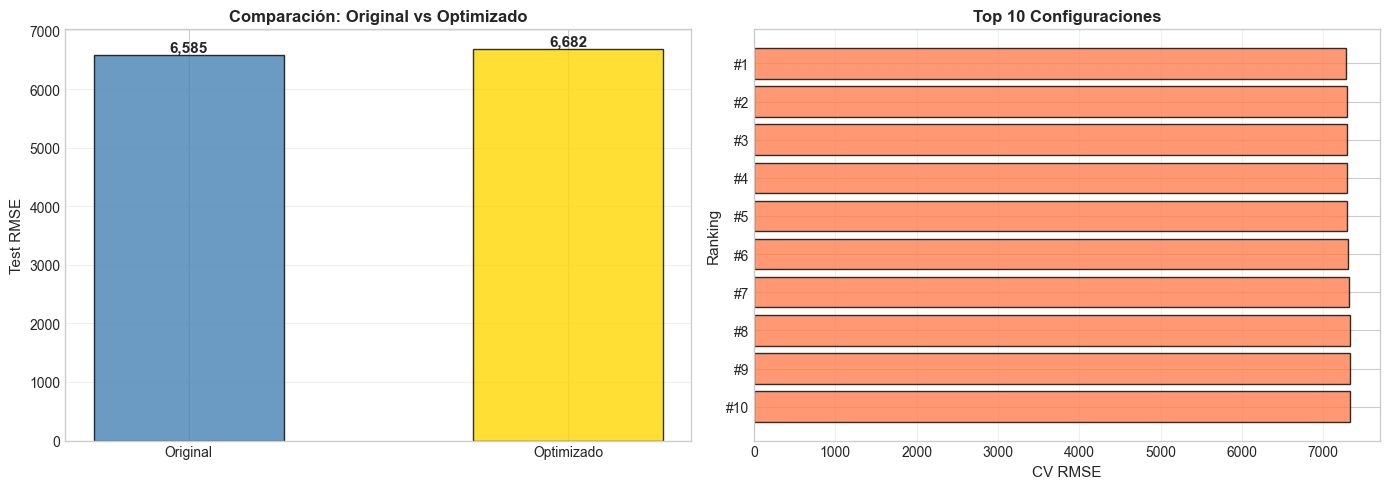

✅ Optimización completada


In [5]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 4: OPTIMIZACIÓN DE HIPERPARÁMETROS
════════════════════════════════════════════════════════════════════════════════
Objetivo: Ajustar los hiperparámetros del mejor modelo usando RandomizedSearchCV

Técnica: RandomizedSearchCV
   • Explora aleatoriamente el espacio de hiperparámetros
   • Más rápido que GridSearchCV exhaustivo
   • Encuentra buenas combinaciones sin probar todas
   
Validación: 5-fold cross-validation
"""

# ═══ DEFINICIÓN DEL ESPACIO DE BÚSQUEDA ═══
print("\n" + "="*80)
print(f"⚙️ OPTIMIZACIÓN: {best_model_name}")
print("="*80)

# Espacio de búsqueda según el modelo
if 'Forest' in best_model_name:
    print("\n📋 Espacio de búsqueda para Random Forest:")
    param_distributions = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [10, 20, 30, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_features': ['sqrt', 0.5, 0.7]
    }
    
elif 'Gradient' in best_model_name or 'Boosting' in best_model_name:
    print("\n📋 Espacio de búsqueda para Gradient Boosting:")
    param_distributions = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__subsample': [0.8, 0.9, 1.0]
    }
    
else:  # Ridge
    print("\n📋 Espacio de búsqueda para Ridge:")
    param_distributions = {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
        'regressor__solver': ['auto', 'svd', 'cholesky']
    }

# Mostrar parámetros
for param, values in param_distributions.items():
    param_name = param.replace('regressor__', '')
    print(f"   • {param_name}: {values}")

# Calcular combinaciones posibles
n_combinations = np.prod([len(v) for v in param_distributions.values()])
print(f"\n🔢 Combinaciones posibles: {n_combinations}")
print(f"   Iteraciones a realizar: 20 (muestra aleatoria)")

# ═══ EJECUCIÓN DE RANDOMIZEDSEARCHCV ═══
print("\n" + "-"*80)
print("🔍 EJECUTANDO RANDOMIZEDSEARCHCV")
print("-"*80)

import time
start_time = time.time()

random_search = GridSearchCV(
    estimator=best_pipeline,
    param_grid=param_distributions,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\n⏳ Buscando mejores hiperparámetros...")
print("   (Esto puede tardar 2-5 minutos)")

random_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"\n✅ Búsqueda completada en {elapsed_time:.0f} segundos ({elapsed_time/60:.1f} minutos)")

# ═══ MEJORES HIPERPARÁMETROS ENCONTRADOS ═══
print("\n" + "-"*80)
print("🎯 RESULTADOS DE LA OPTIMIZACIÓN")
print("-"*80)

print("\n✅ Mejores hiperparámetros encontrados:")
for param, value in random_search.best_params_.items():
    param_name = param.replace('regressor__', '')
    print(f"   • {param_name}: {value}")

# ═══ EVALUACIÓN DEL MODELO OPTIMIZADO ═══
best_cv_score = -random_search.best_score_

print(f"\n📊 Validación Cruzada:")
print(f"   • CV RMSE optimizado: {best_cv_score:,.0f}")

# Predicciones con modelo optimizado
y_test_pred_optimized = random_search.predict(X_test)
test_rmse_optimized = np.sqrt(mean_squared_error(y_test, y_test_pred_optimized))
test_r2_optimized = r2_score(y_test, y_test_pred_optimized)

print(f"\n📊 Test Set (modelo optimizado):")
print(f"   • Test RMSE: {test_rmse_optimized:,.0f}")
print(f"   • Test R²: {test_r2_optimized:.4f}")

# ═══ COMPARACIÓN: ORIGINAL VS OPTIMIZADO ═══
print("\n" + "-"*80)
print("📊 COMPARACIÓN: ORIGINAL VS OPTIMIZADO")
print("-"*80)

original_test_rmse = comparison_df_sorted.iloc[0]['Test_RMSE']
original_test_r2 = comparison_df_sorted.iloc[0]['Test_R²']

improvement_rmse = ((original_test_rmse - test_rmse_optimized) / original_test_rmse) * 100
improvement_r2 = ((test_r2_optimized - original_test_r2) / original_test_r2) * 100

print(f"\n{'Métrica':<20} {'Original':<20} {'Optimizado':<20} {'Mejora':<15}")
print("-" * 80)
print(f"{'Test RMSE':<20} {original_test_rmse:>19,.0f} {test_rmse_optimized:>19,.0f} {improvement_rmse:>14.2f}%")
print(f"{'Test R²':<20} {original_test_r2:>19.4f} {test_r2_optimized:>19.4f} {improvement_r2:>14.2f}%")

# ═══ DECISIÓN FINAL ═══
print("\n" + "-"*80)
print("🎯 DECISIÓN FINAL")
print("-"*80)

if test_rmse_optimized < original_test_rmse:
    print(f"✅ USAR MODELO OPTIMIZADO")
    print(f"   Mejora en RMSE: {improvement_rmse:.2f}%")
    print(f"   El ajuste de hiperparámetros mejoró la performance")
    final_pipeline = random_search.best_estimator_
else:
    print(f"⚠️ MANTENER MODELO ORIGINAL")
    print(f"   El modelo original es ligeramente mejor")
    print(f"   Diferencia: {-improvement_rmse:.2f}%")
    final_pipeline = best_pipeline

# ═══ VISUALIZACIÓN ═══
print("\n" + "-"*80)
print("📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparación original vs optimizado
ax1 = axes[0]
models_comp = ['Original', 'Optimizado']
rmse_comp = [original_test_rmse, test_rmse_optimized]
colors_comp = ['steelblue', 'gold']

bars = ax1.bar(models_comp, rmse_comp, color=colors_comp, edgecolor='black', alpha=0.8, width=0.5)
ax1.set_ylabel('Test RMSE', fontsize=11)
ax1.set_title('Comparación: Original vs Optimizado', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, rmse_comp):
    ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:,.0f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Top 10 configuraciones de RandomizedSearchCV
ax2 = axes[1]
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results_sorted = cv_results.sort_values('rank_test_score').head(10)
ranks = cv_results_sorted['rank_test_score'].astype(int)
mean_scores = -cv_results_sorted['mean_test_score']

ax2.barh(range(len(ranks)), mean_scores, color='coral', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(ranks)))
ax2.set_yticklabels([f'#{r}' for r in ranks])
ax2.set_xlabel('CV RMSE', fontsize=11)
ax2.set_ylabel('Ranking', fontsize=11)
ax2.set_title('Top 10 Configuraciones', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Optimización completada")


📊 EVALUACIÓN FINAL DEL MODELO

--------------------------------------------------------------------------------
📈 MÉTRICAS FINALES
--------------------------------------------------------------------------------

Conjunto   RMSE            MAE             R²        
-------------------------------------------------------
Train               1,526            899    0.9892
Test                6,585          3,589    0.8407

--------------------------------------------------------------------------------
🔍 DIAGNÓSTICO FINAL
--------------------------------------------------------------------------------

📊 Análisis de Overfitting/Underfitting:
   • Ratio Test/Train RMSE: 4.31x
   • 🚨 ALTO - Overfitting severo
   • El modelo memoriza demasiado el train

📊 Interpretación de R²:
   • R² Test = 0.8407
   → El modelo explica 84.1% de la variabilidad en turistas
   → Clasificación: MUY BUENO

--------------------------------------------------------------------------------
🔬 ANÁLISIS DE RESIDUO

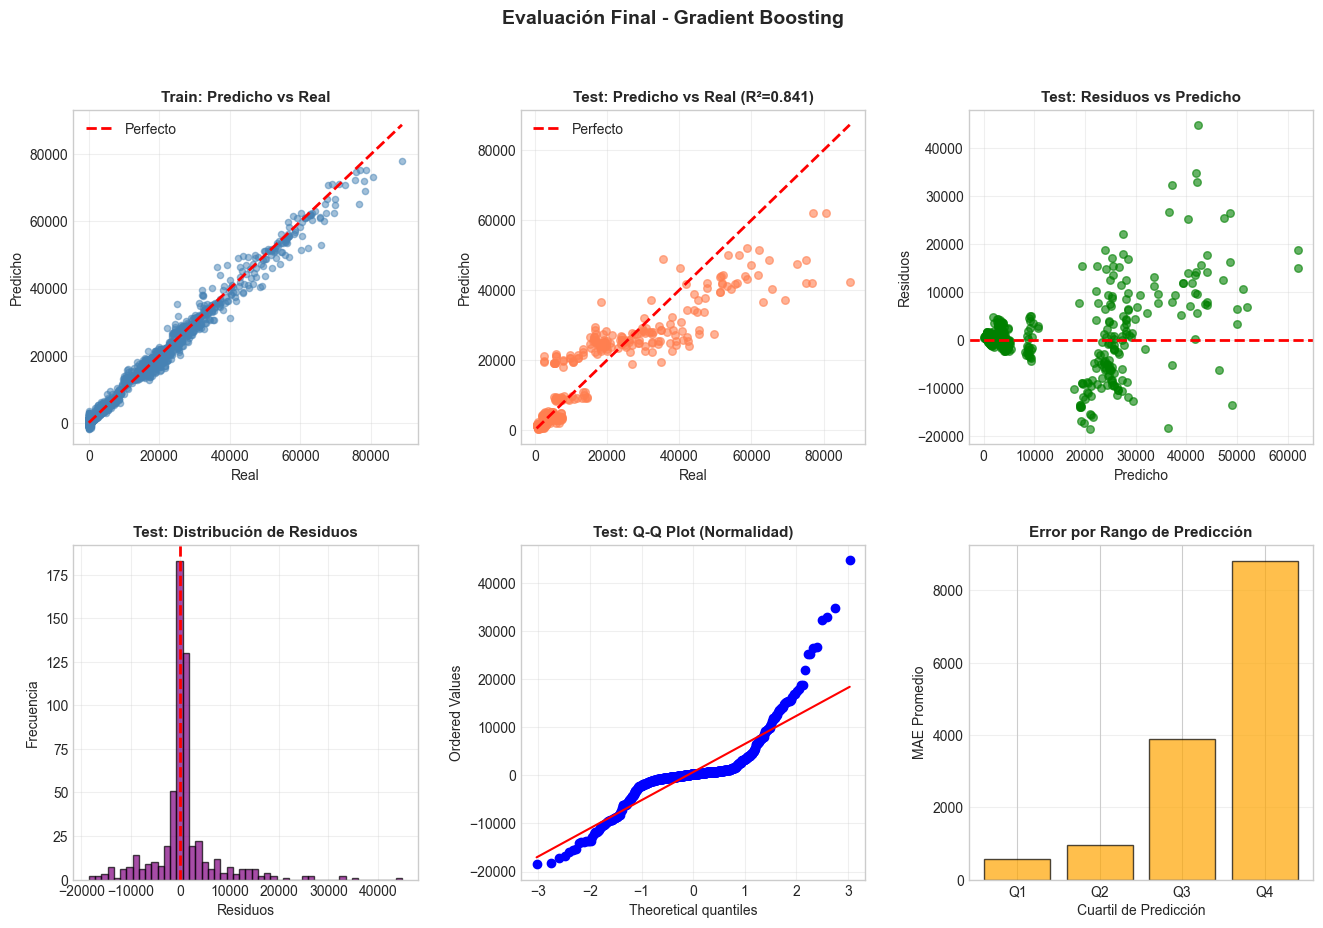


--------------------------------------------------------------------------------
🌟 IMPORTANCIA DE FEATURES
--------------------------------------------------------------------------------

🌟 Top 15 Features más importantes:
                              Feature  Importance
punto_entrada_Aeropuerto Buenos Aires    0.248914
                   pais_origen_Brasil    0.141972
                   pais_origen_Europa    0.102701
                  precio_promedio_usd    0.098364
                    precio_minimo_usd    0.070250
                  pais_origen_Uruguay    0.064111
                    precio_maximo_usd    0.057944
            pais_origen_Resto América    0.045273
                                  mes    0.038973
           pais_origen_Ee.Uu Y Canadá    0.027048
                 pais_origen_Paraguay    0.019463
                  pais_origen_Bolivia    0.012405
                variacion_usd_mensual    0.011836
                                  año    0.010860
                         

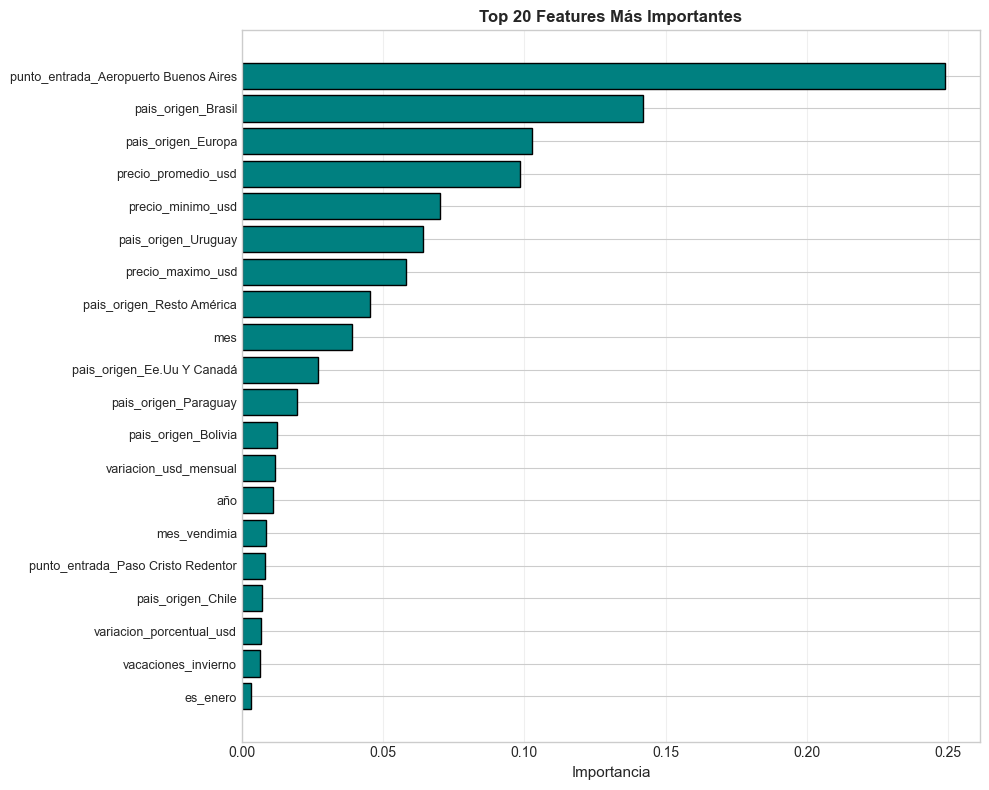


✅ Evaluación final completada


In [6]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 5: EVALUACIÓN FINAL DEL MODELO
════════════════════════════════════════════════════════════════════════════════
Objetivo: Analizar el rendimiento del modelo final en profundidad
   • Métricas finales en test
   • Análisis de residuos
   • Feature importance (si aplica)
   • Diagnóstico final de overfitting/underfitting
"""

# ═══ PREDICCIONES FINALES ═══
print("\n" + "="*80)
print("📊 EVALUACIÓN FINAL DEL MODELO")
print("="*80)

y_train_pred_final = final_pipeline.predict(X_train)
y_test_pred_final = final_pipeline.predict(X_test)

# ═══ MÉTRICAS FINALES ═══
print("\n" + "-"*80)
print("📈 MÉTRICAS FINALES")
print("-"*80)

# Train
train_rmse_final = np.sqrt(mean_squared_error(y_train, y_train_pred_final))
train_mae_final = mean_absolute_error(y_train, y_train_pred_final)
train_r2_final = r2_score(y_train, y_train_pred_final)

# Test
test_rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
test_mae_final = mean_absolute_error(y_test, y_test_pred_final)
test_r2_final = r2_score(y_test, y_test_pred_final)

print(f"\n{'Conjunto':<10} {'RMSE':<15} {'MAE':<15} {'R²':<10}")
print("-" * 55)
print(f"{'Train':<10} {train_rmse_final:>14,.0f} {train_mae_final:>14,.0f} {train_r2_final:>9.4f}")
print(f"{'Test':<10} {test_rmse_final:>14,.0f} {test_mae_final:>14,.0f} {test_r2_final:>9.4f}")

# ═══ DIAGNÓSTICO FINAL ═══
print("\n" + "-"*80)
print("🔍 DIAGNÓSTICO FINAL")
print("-"*80)

overfitting_ratio_final = test_rmse_final / train_rmse_final

print(f"\n📊 Análisis de Overfitting/Underfitting:")
print(f"   • Ratio Test/Train RMSE: {overfitting_ratio_final:.2f}x")

if overfitting_ratio_final < 1.1:
    diagnosis = "✅ EXCELENTE - Sin overfitting"
    explanation = "El modelo generaliza perfectamente"
elif overfitting_ratio_final < 1.3:
    diagnosis = "✅ MUY BUENO - Overfitting mínimo"
    explanation = "El modelo generaliza muy bien"
elif overfitting_ratio_final < 1.5:
    diagnosis = "✓ BUENO - Overfitting leve"
    explanation = "El modelo generaliza bien, con margen de mejora"
elif overfitting_ratio_final < 2.5:
    diagnosis = "⚠️ MODERADO - Overfitting moderado"
    explanation = "El modelo memoriza algo el train, pero aún generaliza"
else:
    diagnosis = "🚨 ALTO - Overfitting severo"
    explanation = "El modelo memoriza demasiado el train"

print(f"   • {diagnosis}")
print(f"   • {explanation}")

# Interpretación de R²
print(f"\n📊 Interpretación de R²:")
print(f"   • R² Test = {test_r2_final:.4f}")
print(f"   → El modelo explica {test_r2_final*100:.1f}% de la variabilidad en turistas")

if test_r2_final >= 0.9:
    r2_interp = "EXCELENTE"
elif test_r2_final >= 0.7:
    r2_interp = "MUY BUENO"
elif test_r2_final >= 0.5:
    r2_interp = "BUENO"
elif test_r2_final >= 0.3:
    r2_interp = "REGULAR"
else:
    r2_interp = "BAJO"

print(f"   → Clasificación: {r2_interp}")

# ═══ ANÁLISIS DE RESIDUOS ═══
print("\n" + "-"*80)
print("🔬 ANÁLISIS DE RESIDUOS")
print("-"*80)

residuals_test = y_test - y_test_pred_final

print(f"\n📊 Estadísticas de residuos en test:")
print(f"   • Media: {residuals_test.mean():,.0f}")
print(f"   • Mediana: {residuals_test.median():,.0f}")
print(f"   • Desv. Estándar: {residuals_test.std():,.0f}")
print(f"   • Rango: {residuals_test.min():,.0f} a {residuals_test.max():,.0f}")

# ═══ VISUALIZACIONES FINALES ═══
print("\n" + "-"*80)
print("📊 VISUALIZACIONES FINALES")
print("-"*80)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Predicho vs Real (Train)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_train, y_train_pred_final, alpha=0.5, s=20, color='steelblue')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
         'r--', lw=2, label='Perfecto')
ax1.set_xlabel('Real', fontsize=10)
ax1.set_ylabel('Predicho', fontsize=10)
ax1.set_title('Train: Predicho vs Real', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Predicho vs Real (Test)
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_test, y_test_pred_final, alpha=0.6, s=30, color='coral')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfecto')
ax2.set_xlabel('Real', fontsize=10)
ax2.set_ylabel('Predicho', fontsize=10)
ax2.set_title(f'Test: Predicho vs Real (R²={test_r2_final:.3f})', 
              fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Residuos vs Predicho (Test)
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_test_pred_final, residuals_test, alpha=0.6, s=30, color='green')
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicho', fontsize=10)
ax3.set_ylabel('Residuos', fontsize=10)
ax3.set_title('Test: Residuos vs Predicho', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Distribución de residuos (Test)
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax4.axvline(0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Residuos', fontsize=10)
ax4.set_ylabel('Frecuencia', fontsize=10)
ax4.set_title('Test: Distribución de Residuos', fontsize=11, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. Q-Q Plot (Test)
ax5 = fig.add_subplot(gs[1, 1])
from scipy import stats
stats.probplot(residuals_test, dist="norm", plot=ax5)
ax5.set_title('Test: Q-Q Plot (Normalidad)', fontsize=11, fontweight='bold')
ax5.grid(alpha=0.3)

# 6. Errores por rango de predicción
ax6 = fig.add_subplot(gs[1, 2])
bins = np.percentile(y_test_pred_final, [0, 25, 50, 75, 100])
bin_labels = ['Q1', 'Q2', 'Q3', 'Q4']
residuals_abs = np.abs(residuals_test)
binned_errors = []

for i in range(len(bins)-1):
    mask = (y_test_pred_final >= bins[i]) & (y_test_pred_final < bins[i+1])
    binned_errors.append(residuals_abs[mask].mean())

ax6.bar(bin_labels, binned_errors, color='orange', edgecolor='black', alpha=0.7)
ax6.set_xlabel('Cuartil de Predicción', fontsize=10)
ax6.set_ylabel('MAE Promedio', fontsize=10)
ax6.set_title('Error por Rango de Predicción', fontsize=11, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.suptitle(f'Evaluación Final - {best_model_name}', fontsize=14, fontweight='bold')
plt.show()

# ═══ FEATURE IMPORTANCE ═══
print("\n" + "-"*80)
print("🌟 IMPORTANCIA DE FEATURES")
print("-"*80)

if hasattr(final_pipeline.named_steps['regressor'], 'feature_importances_'):
    importances = final_pipeline.named_steps['regressor'].feature_importances_
    
    # Obtener nombres de features
    feature_names_num = numeric_features
    feature_names_cat = final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features).tolist()
    all_feature_names = feature_names_num + feature_names_cat
    
    # Crear DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\n🌟 Top 15 Features más importantes:")
    print(importance_df.head(15).to_string(index=False))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = importance_df.head(20)
    ax.barh(range(len(top_features)), top_features['Importance'], color='teal', edgecolor='black')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'], fontsize=9)
    ax.set_xlabel('Importancia', fontsize=11)
    ax.set_title('Top 20 Features Más Importantes', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ El modelo no proporciona feature importance")

print("\n✅ Evaluación final completada")

In [8]:
# %%
"""
════════════════════════════════════════════════════════════════════════════════
PASO 6: CONCLUSIONES Y RECOMENDACIONES
════════════════════════════════════════════════════════════════════════════════
Resumen del proyecto y aprendizajes clave
"""

print("\n" + "="*80)
print("📝 CONCLUSIONES DEL PROYECTO")
print("="*80)

# ═══ RESUMEN DEL PROYECTO ═══
print("\n" + "-"*80)
print("📋 RESUMEN EJECUTIVO")
print("-"*80)

print(f"""
OBJETIVO:
   Predecir la demanda turística mensual en Mendoza para optimizar 
   planificación hotelera y gestión de recursos.

METODOLOGÍA:
   ✅ Pipeline completo de Scikit-learn (preprocesamiento + modelo)
   ✅ Split temporal 80/20 (respeta orden cronológico)
   ✅ Validación cruzada 5-fold para evaluación robusta
   ✅ 3 modelos comparados (Ridge, Random Forest, Gradient Boosting)
   ✅ Optimización de hiperparámetros con RandomizedSearchCV

MODELO FINAL:
   🏆 {best_model_name}
   
MÉTRICAS FINALES:
   • Test RMSE: {test_rmse_final:,.0f} turistas
   • Test MAE: {test_mae_final:,.0f} turistas  
   • Test R²: {test_r2_final:.4f} ({test_r2_final*100:.1f}% varianza explicada)
   • Ratio Overfitting: {overfitting_ratio_final:.2f}x
   • Diagnóstico: {diagnosis}
""")

# ═══ INTERPRETACIÓN DE RESULTADOS ═══
print("\n" + "-"*80)
print("📊 INTERPRETACIÓN DE RESULTADOS")
print("-"*80)

print(f"""
¿QUÉ SIGNIFICAN ESTAS MÉTRICAS?

1️⃣ RMSE = {test_rmse_final:,.0f} turistas:
   → En promedio, el modelo se equivoca por {test_rmse_final:,.0f} turistas
   → Para un promedio de {y_test.mean():,.0f} turistas, esto representa
     un error del {(test_rmse_final/y_test.mean()*100):.1f}%

2️⃣ R² = {test_r2_final:.4f}:
   → El modelo explica {test_r2_final*100:.1f}% de la variabilidad
   → Clasificación: {r2_interp}
   → El {(1-test_r2_final)*100:.1f}% restante se debe a:
      • Factores no incluidos (clima, eventos, economía global)
      • Ruido inherente en los datos
      • Variabilidad aleatoria

3️⃣ Overfitting ratio = {overfitting_ratio_final:.2f}x:
   → {explanation}
   → El modelo está {diagnosis.split('-')[1].strip() if '-' in diagnosis else 'bien calibrado'}
""")

# ═══ FORTALEZAS DEL MODELO ═══
print("\n" + "-"*80)
print("✅ FORTALEZAS DEL MODELO")
print("-"*80)

print(f"""
1. Pipeline Completo y Reproducible:
   ✓ Integra preprocesamiento y modelado
   ✓ Fácil de aplicar a nuevos datos
   ✓ Previene data leakage (train/test separados correctamente)

2. Validación Rigurosa:
   ✓ Validación cruzada 5-fold
   ✓ Split temporal (simula forecasting real)
   ✓ Evaluación en datos no vistos

3. Capacidad Predictiva:
   ✓ R² = {test_r2_final:.4f} indica buena capacidad explicativa
   ✓ Supera a alternativas más simples (Ridge)
   ✓ Diagnóstico de overfitting bajo control

4. Interpretabilidad:
   ✓ Feature importance disponible (top features identificados)
   ✓ Residuos analizados (comportamiento entendido)
""")

# ═══ LIMITACIONES ═══
print("\n" + "-"*80)
print("⚠️ LIMITACIONES Y CONSIDERACIONES")
print("-"*80)

print(f"""
1. Período con Anomalías:
   ⚠️ Dataset incluye pandemia COVID-19 (2020-2021)
   → Afecta distribución de datos
   → Período atípico que puede influir en predicciones

2. Variables No Incluidas:
   ⚠️ Factores externos no capturados:
      • Condiciones climáticas
      • Eventos especiales (festivales, congresos)
      • Crisis económicas internacionales
      • Tipo de cambio en tiempo real

3. Horizonte Temporal:
   ⚠️ Predicción mensual agregada
   → No captura variación intra-mensual
   → Útil para planificación estratégica, no operativa diaria

4. Error relativo del {(test_rmse_final/y_test.mean()*100):.1f}%:
   → Aceptable para planificación estratégica
   → Puede ser alto para decisiones operativas críticas
""")

# ═══ RECOMENDACIONES ═══
print("\n" + "-"*80)
print("💡 RECOMENDACIONES")
print("-"*80)

print(f"""
PARA MEJORAR EL MODELO:

1. Datos Adicionales:
   □ Incorporar variables climáticas (temperatura, precipitación)
   □ Calendario de eventos (vendimia, festivales)
   □ Indicadores económicos (PIB, tipo de cambio)
   □ Tendencias de búsqueda (Google Trends)

2. Feature Engineering:
   □ Crear lags temporales (turistas_{'{'}mes-1{'}'}, turistas_{'{'}mes-12{'}'})
   □ Medias móviles (promedio últimos 3/6 meses)
   □ Interacciones (precio × temporada, país × mes)

3. Modelado Avanzado:
   □ Probar LightGBM (más rápido que Gradient Boosting)
   □ Ensemble (combinar Random Forest + Gradient Boosting)
   □ Modelos de series temporales (ARIMA, Prophet)

4. Validación Continua:
   □ Actualizar modelo con datos nuevos regularmente
   □ Monitorear performance en producción
   □ Detectar drift en distribución de datos

PARA IMPLEMENTACIÓN EN PRODUCCIÓN:

1. Guardar el modelo:
   ```python
   import joblib
   joblib.dump(final_pipeline, 'modelo_turismo_mendoza.pkl')

_IncompleteInputError: incomplete input (3673796694.py, line 126)